# imports of different inbuilt libraries
## Yellowbrick is for visualization
## Eli5 is for feature imprtance checking and weight checking
## Others are well known already

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas_profiling as pds
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy as sc
import ast
from scipy.sparse import hstack
from sklearn.feature_extraction.text import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import PrecisionRecallCurve
import eli5
from eli5 import show_prediction

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


# This cell is do get data from json file 
## Then rename and all other simple stuff

In [2]:
def getData(file):
    data = pd.read_json(file,lines=True)
    data.drop('id',axis=1, inplace=True)
    data.rename(columns = {'lista_asm': 'Instructions', 'cfg': 'FlowGraphs' ,'semantic' : 'Class'}, inplace = True)
    return data

# This one i am using to use the Graph infromation
## Like adjacency and number of nodes

In [3]:
def useGraphDetails(data):  
    stored =[]
    for v in  data['FlowGraphs']:
        nodes = v.get('nodes')
        adjacency = v.get('adjacency')
        length_node = len(nodes)
        double_adjaceny = []
        single_adjacency = []
        for x in adjacency:
            try:
                double_adjaceny.append((x[0]['id'],x[1]['id'])[0])

            except:
                if len(x)!=0:
                    single_adjacency.append(x[0]['id'])
        try:
            x = length_node/len(double_adjaceny)
        except:
            x= 0
        try:
            y= length_node/len(single_adjacency)
        except:
            y=0
        stored.append([length_node ,x ,y])
    return stored

# Here i am using instruction set to get some features
## These will be used in vectorization using td_idf 

In [4]:
def useInstructions(data):
    text=[]
    X=[]
    for row in data.Instructions:
        row = ast.literal_eval(row)
        for string in row:
            word= string.split()[0]
            text.append(word)
        row=" ".join(text)
        X.append(row)
        text=[]
    return X

# Intializing the Vectorization and getting sparse matrices as output

In [5]:
def getVectorizedInstructions(X):
    tf = TfidfVectorizer(use_idf=True, tokenizer = None, ngram_range=(1,3) )
    vector= tf.fit_transform(X)
    columns = ['length_node','legth_double','length_single']
    columns.extend(tf.get_feature_names())
    return vector , columns,tf

# Now some data is in sparse matrix form and some in array format ,stacking it    to bring in same format

In [6]:
def stackTheData(stored,vector):
    stored = sc.sparse.csr_matrix(stored)
    dataset = hstack((stored, vector))  
    # dataset= dataset.toarray()
    y = data.Class
    X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.3, random_state=20)
    return X_train, X_test, y_train, y_test

# Training the model after so much of parameter tunning 

In [7]:
def buildModel(X_train, y_train):
    model=LogisticRegression( penalty='l1' ,class_weight=None, solver='liblinear')
    model.fit(X_train, y_train)
    return model

In [8]:
data = getData('noduplicatedataset.json')

In [12]:
data['FlowGraphs'][0]

{'directed': True,
 'graph': [],
 'nodes': [{'id': 4276480,
   'asm': '554889e54883ec2048897df048837df0000f841d000000',
   'label': '0x414100:\tpush\trbp\n0x414101:\tmov\trbp, rsp\n0x414104:\tsub\trsp, 0x20\n0x414108:\tmov\tqword ptr [rbp - 0x10], rdi\n0x41410c:\tcmp\tqword ptr [rbp - 0x10], 0\n0x414111:\tje\t0x414134'},
  {'id': 4276608,
   'asm': '8945e048637de0e8c4c6feff',
   'label': '0x414180:\tmov\tdword ptr [rbp - 0x20], eax\n0x414183:\tmovsxd\trdi, dword ptr [rbp - 0x20]\n0x414187:\tcall\t0x400850'},
  {'id': 4276743,
   'asm': '488b45e8488b7808488b45f0488b7008486355e4e810c6feff',
   'label': '0x414207:\tmov\trax, qword ptr [rbp - 0x18]\n0x41420b:\tmov\trdi, qword ptr [rax + 8]\n0x41420f:\tmov\trax, qword ptr [rbp - 0x10]\n0x414213:\tmov\trsi, qword ptr [rax + 8]\n0x414217:\tmovsxd\trdx, dword ptr [rbp - 0x1c]\n0x41421b:\tcall\t0x400830'},
  {'id': 4276620,
   'asm': '488b7de848894708488b45e848837808000f8547000000',
   'label': '0x41418c:\tmov\trdi, qword ptr [rbp - 0x18]\n0x41

In [13]:
stored = useGraphDetails(data)

In [15]:
instructions = useInstructions(data)

In [16]:
instructions

['jmp jmp jmp push mov mov cmp jge push mov sub mov cmp je mov cmp jl mov cmp jne mov jmp mov mov call mov cmp jne mov jmp mov mov mov mov add mov call mov movsxd call mov mov mov cmp jne mov add mov movsxd call mov mov mov cmp jne mov mov call mov jmp jmp mov mov mov mov mov mov cmp je mov mov mov mov movsxd call mov movsxd mov mov mov mov mov mov add pop ret mov add pop ret',
 'ucomisd jp ucomisd jp pxor ucomisd jae ucomisd jae pxor ucomisd jb test je movapd test je movsd divsd jmp addsd addsd jmp pxor divsd movapd ret movapd ret pxor test jne movsd jmp push push sub mov mov divsd call movapd xorpd test je',
 'push mov mov mov xor nop mov lea sar shr lea mov and neg lea mov shr sar cdqe movzx and shl movzx mov and shr mov sar shr add sar movsxd movzx or mov inc cmp jne mov lea sar shr lea mov and neg lea mov shr sar cdqe movzx and shl movzx mov and shr mov sar shr add sar movsxd movzx or mov inc cmp jne mov mov mov mov mov nop mov mov mov xor nop mov lea sar shr lea mov and neg lea m

In [17]:
vector , columns,tf  =  getVectorizedInstructions(instructions)

In [19]:
vector

<6073x18039 sparse matrix of type '<class 'numpy.float64'>'
	with 779124 stored elements in Compressed Sparse Row format>

# Calling to the above mentioned steps

In [20]:
data = getData('noduplicatedataset.json')
stored = useGraphDetails(data)
instructions = useInstructions(data)
vector , columns,tf  =  getVectorizedInstructions(instructions)
X_train, X_test, y_train, y_test  =  stackTheData(stored,vector)
model = buildModel(X_train, y_train)

# Showing some highlights of data

In [ ]:
pds.ProfileReport(data)

# Different visualization techniques for Checking the results

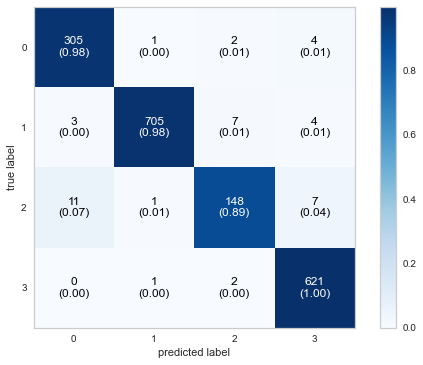

In [21]:
y_pred = model.predict(X_test)
cm= confusion_matrix(y_test,y_pred)
fig1, ax1 = plot_confusion_matrix(conf_mat=cm,colorbar=True,show_absolute=True,show_normed=True)

In [22]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

  encryption       0.96      0.98      0.97       312
        math       1.00      0.98      0.99       719
        sort       0.93      0.89      0.91       167
      string       0.98      1.00      0.99       624

    accuracy                           0.98      1822
   macro avg       0.96      0.96      0.96      1822
weighted avg       0.98      0.98      0.98      1822



# Using the yellobrick to visualization very powerful library

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


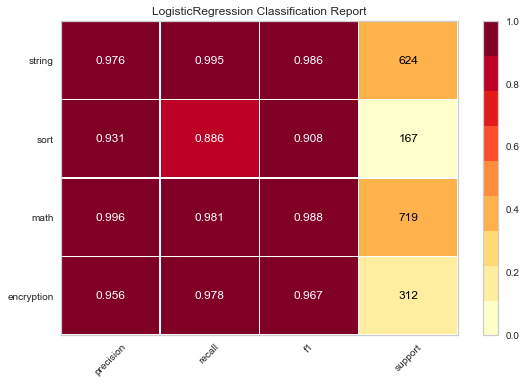

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


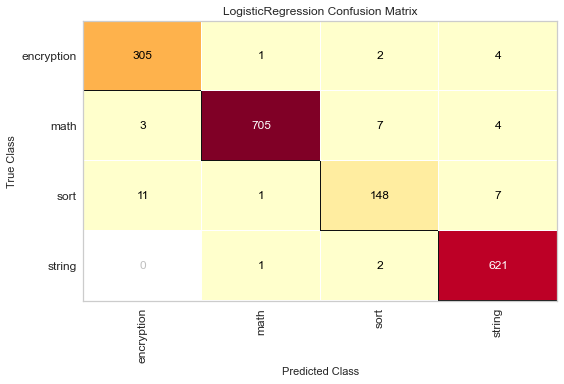

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


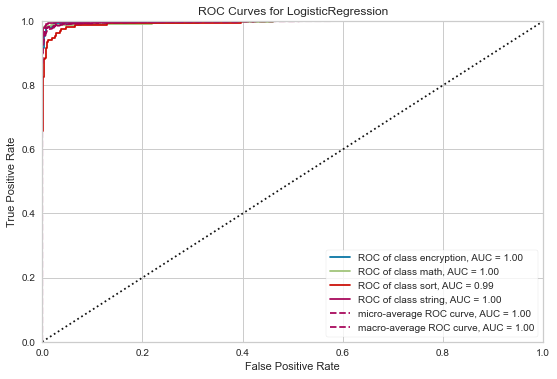

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


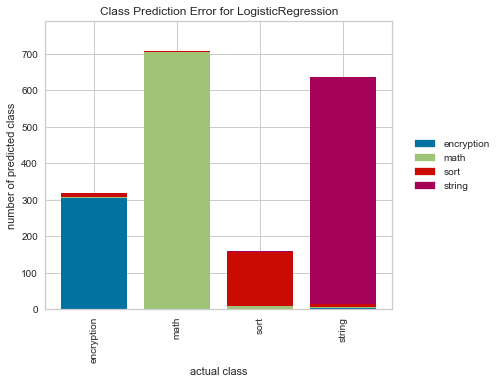

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


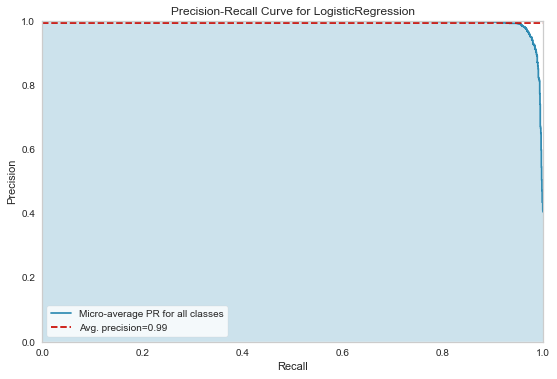

In [23]:
classes= ['encryption','math','sort','string']
visualizer = ClassificationReport(model, classes=classes, support=True)
visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)       
visualizer.show()                       
cm = ConfusionMatrix(model, classes=classes)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()
visualizer = ROCAUC(model, classes=classes)
visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)       
visualizer.show()  
visualizer = ClassPredictionError(model, classes=classes )
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()
viz = PrecisionRecallCurve(model)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

# Using the eli5  library to visualize the weights and contribution of weights

In [24]:
eli5.show_weights(model ,feature_names=columns ,top=30)

# Using the same library for one example

In [25]:
show_prediction(model,X_test[99],feature_names=columns,show_feature_values=True)

# Generating the Result on Blindtest and saving in pwd as resultBlind.txt

In [ ]:
org = pd.read_json('blindtest.json',lines=True)
data = org.copy()
data.drop('id',axis=1, inplace=True)
data.rename(columns = {'lista_asm': 'Instructions', 'cfg': 'FlowGraphs' }, inplace = True)
stored = useGraphDetails(data)
instructions = useInstructions(data)
vector= tf.transform(instructions)
stored = sc.sparse.csr_matrix(stored)
bindData = hstack((stored, vector)) 
y_pred = model.predict(bindData)
org['prediction'] = y_pred
org['prediction'].to_csv('resultBlind.txt',index=False)

In [3]:
data = pd.read_json('dup_blindtest.json',lines=True)

In [6]:
data1 = pd.read_csv('1946707.txt')

In [7]:
data1

,prediction
0,encryption
1,math
2,string
3,string
4,math
...,...
752,math
753,string
754,encryption
755,math


In [5]:
data['semantic'] 

0      encryption
1            math
2          string
3          string
4            math
          ...    
752          math
753    encryption
754    encryption
755          math
756          math
Name: semantic, Length: 757, dtype: object

In [9]:
data['prediction'] = data1['prediction']

In [10]:
data

,id,semantic,lista_asm,cfg,prediction
0,10351,encryption,"['jmp qword ptr [rip + 0x203b72]', 'jmp qword ...","{'directed': True, 'graph': [], 'nodes': [{'id...",encryption
1,14513,math,"['sub rsp, 0x28', 'mov rax, qword ptr fs:[0x28...","{'directed': True, 'graph': [], 'nodes': [{'id...",math
2,1767,string,"['jmp qword ptr [rip + 0x200bc2]', 'jmp qword ...","{'directed': True, 'graph': [], 'nodes': [{'id...",string
3,9384,string,"['jmp qword ptr [rip + 0x2177ea]', 'jmp qword ...","{'directed': True, 'graph': [], 'nodes': [{'id...",string
4,3018,math,"['ucomisd xmm1, xmm1', 'movapd xmm7, xmm0', 'm...","{'directed': True, 'graph': [], 'nodes': [{'id...",math
...,...,...,...,...,...
752,9661,math,"['ucomisd xmm1, xmm1', 'setp dl', 'ucomisd xmm...","{'directed': True, 'graph': [], 'nodes': [{'id...",math
753,6933,encryption,"['lea r8, [rdi + 7]', 'mov r10d, 0x601acf', 'm...","{'directed': True, 'graph': [], 'nodes': [{'id...",string
754,11954,encryption,"['push r14', 'push rbx', 'sub rsp, 0x28', 'lea...","{'directed': True, 'graph': [], 'nodes': [{'id...",encryption
755,5769,math,"['push rbp', 'mov rbp, rsp', 'sub rsp, 0xb0', ...","{'directed': True, 'graph': [], 'nodes': [{'id...",math


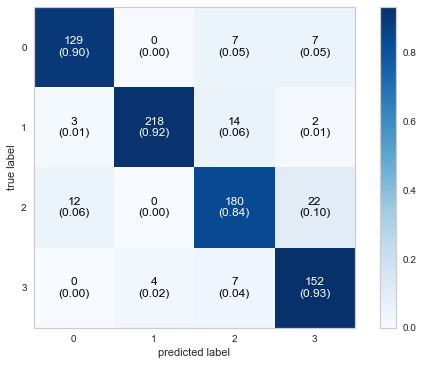

In [11]:
cm= confusion_matrix(data['semantic'],data['prediction'])
fig1, ax1 = plot_confusion_matrix(conf_mat=cm,colorbar=True,show_absolute=True,show_normed=True)

In [12]:
print(classification_report(data['semantic'],data['prediction']))

              precision    recall  f1-score   support

  encryption       0.90      0.90      0.90       143
        math       0.98      0.92      0.95       237
        sort       0.87      0.84      0.85       214
      string       0.83      0.93      0.88       163

    accuracy                           0.90       757
   macro avg       0.89      0.90      0.90       757
weighted avg       0.90      0.90      0.90       757

